In [1]:
import torch 
from torch import nn
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import pandas as pd
import os

In [ ]:
# download data - https://www.kaggle.com/competitions/journey-springfield

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_WORKERS = os.cpu_count()
IMG_SIZE = 64
DEVICE, NUM_WORKERS, IMG_SIZE

('cuda', 12, 64)

In [3]:
trans = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

In [4]:
TRAIN_PATH = Path("data/train/simpsons_dataset")
TEST_PATH = Path("data/test")

dataset = ImageFolder(root=TRAIN_PATH,
                       transform=trans)

dataset

Dataset ImageFolder
    Number of datapoints: 20933
    Root location: data/train/simpsons_dataset
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [5]:
dataset[0][0].shape, dataset[0][1]

(torch.Size([3, 64, 64]), 0)

In [6]:
class_names = dataset.classes
class_names

['abraham_grampa_simpson',
 'agnes_skinner',
 'apu_nahasapeemapetilon',
 'barney_gumble',
 'bart_simpson',
 'carl_carlson',
 'charles_montgomery_burns',
 'chief_wiggum',
 'cletus_spuckler',
 'comic_book_guy',
 'disco_stu',
 'edna_krabappel',
 'fat_tony',
 'gil',
 'groundskeeper_willie',
 'homer_simpson',
 'kent_brockman',
 'krusty_the_clown',
 'lenny_leonard',
 'lionel_hutz',
 'lisa_simpson',
 'maggie_simpson',
 'marge_simpson',
 'martin_prince',
 'mayor_quimby',
 'milhouse_van_houten',
 'miss_hoover',
 'moe_szyslak',
 'ned_flanders',
 'nelson_muntz',
 'otto_mann',
 'patty_bouvier',
 'principal_skinner',
 'professor_john_frink',
 'rainier_wolfcastle',
 'ralph_wiggum',
 'selma_bouvier',
 'sideshow_bob',
 'sideshow_mel',
 'snake_jailbird',
 'troy_mcclure',
 'waylon_smithers']

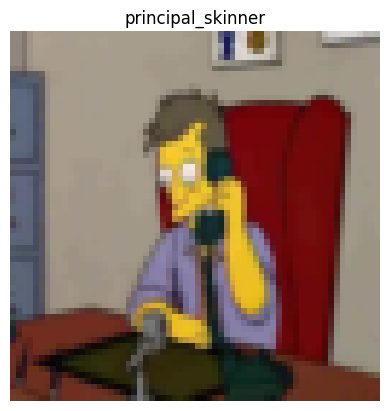

In [7]:
import random

sample = random.choice(dataset)
img, label = sample
plt.imshow(img.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
plt.show()

In [35]:
from sklearn.model_selection import train_test_split
train_ds, test_ds = train_test_split(dataset, test_size=0.2, shuffle=True)

In [36]:
len(train_ds), len(test_ds)

(16746, 4187)

In [37]:
train_ds[0][0].shape, train_ds[0][1], test_ds[0][0].shape, test_ds[0][1]

(torch.Size([3, 64, 64]), 6, torch.Size([3, 64, 64]), 6)

In [38]:
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_ds,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset=test_ds,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS)

len(train_dataloader), len(test_dataloader)

(524, 131)

In [39]:
def accuracy_score(y, y_pred):
    return torch.sum(y == y_pred) / len(y_pred) * 100

In [8]:
class SimpsonsModel(nn.Module):
    def __init__(self, in_channels, output):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(64)

        )
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 64, 3),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout()

        )
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(128)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048, 1024),
            nn.Linear(1024, output)
        )

    def forward(self, x):
        out1 = self.block1(x)
        out2 = self.block2(out1)
        out3 = self.block3(out2)
        return self.classifier(out3)
model = SimpsonsModel(in_channels=3,
                      output=len(class_names)).to(DEVICE)
loss_fn = torch.nn.CrossEntropyLoss()

In [41]:
model(next(iter(train_dataloader))[0][0].unsqueeze(0).to(DEVICE))

tensor([[-0.1310, -0.0943,  0.2134,  0.0763, -0.0304, -0.3811,  0.2641, -0.1138,
          0.1997,  0.0813,  0.1903,  0.0324,  0.3314,  0.5697, -0.4592, -0.2997,
          0.1968,  0.1965, -0.1838,  0.0775,  0.1512, -0.4995, -0.0496, -0.2719,
         -0.0890, -0.1691, -0.6006, -0.1847,  0.6034,  0.1847,  0.5180, -0.4623,
         -0.0112,  0.2538, -0.0835,  0.0472,  0.3398, -0.4168,  0.0254,  0.1842,
         -0.3209, -0.3568]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [42]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 13, 0.1)

train_acc_res = []

test_acc_res = []

In [43]:
from tqdm import tqdm

EPOCHS = 30

for epoch in tqdm(range(EPOCHS)):
    train_acc, test_acc = 0, 0
    for X, y in train_dataloader:
        X, y = X.to(DEVICE), y.to(DEVICE)
        model.train()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        acc = accuracy_score(y, y_pred.argmax(1))
        train_acc += acc
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    for X, y in test_dataloader:
        X, y = X.to(DEVICE), y.to(DEVICE)
        model.eval()
        with torch.inference_mode():
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
        acc = accuracy_score(y, y_pred.argmax(1))
        test_acc += acc
    scheduler.step()
    print(f"EPOCH: {epoch + 1}")
    print(f"train: acc - {train_acc / len(train_dataloader)}%\n")
    print(f"test: acc - {test_acc / len(test_dataloader)}%")
    train_acc_res.append(train_acc / len(train_dataloader))
    test_acc_res.append(test_acc / len(test_dataloader))

  3%|▎         | 1/30 [00:09<04:23,  9.09s/it]

EPOCH: 1
train: acc - 41.51598358154297%

test: acc - 48.68267822265625%


  7%|▋         | 2/30 [00:17<04:10,  8.94s/it]

EPOCH: 2
train: acc - 57.22805404663086%

test: acc - 62.56184387207031%


 10%|█         | 3/30 [00:26<03:59,  8.88s/it]

EPOCH: 3
train: acc - 63.832298278808594%

test: acc - 63.33845901489258%


 13%|█▎        | 4/30 [00:35<03:50,  8.86s/it]

EPOCH: 4
train: acc - 70.55343627929688%

test: acc - 72.97144317626953%


 17%|█▋        | 5/30 [00:44<03:43,  8.94s/it]

EPOCH: 5
train: acc - 74.89981079101562%

test: acc - 73.19939422607422%


 20%|██        | 6/30 [00:53<03:34,  8.93s/it]

EPOCH: 6
train: acc - 76.85234069824219%

test: acc - 76.93843841552734%


 23%|██▎       | 7/30 [01:02<03:27,  9.01s/it]

EPOCH: 7
train: acc - 80.01192474365234%

test: acc - 77.80162811279297%


 27%|██▋       | 8/30 [01:12<03:21,  9.17s/it]

EPOCH: 8
train: acc - 82.3759536743164%

test: acc - 79.9830322265625%


 30%|███       | 9/30 [01:21<03:13,  9.23s/it]

EPOCH: 9
train: acc - 83.01168823242188%

test: acc - 78.51287078857422%


 33%|███▎      | 10/30 [01:30<03:02,  9.15s/it]

EPOCH: 10
train: acc - 84.177001953125%

test: acc - 79.968017578125%


 37%|███▋      | 11/30 [01:39<02:54,  9.17s/it]

EPOCH: 11
train: acc - 86.0842056274414%

test: acc - 79.58634185791016%


 40%|████      | 12/30 [01:49<02:47,  9.28s/it]

EPOCH: 12
train: acc - 86.76287841796875%

test: acc - 84.2857666015625%


 43%|████▎     | 13/30 [01:58<02:38,  9.33s/it]

EPOCH: 13
train: acc - 88.0093002319336%

test: acc - 79.90263366699219%


 47%|████▋     | 14/30 [02:08<02:29,  9.32s/it]

EPOCH: 14
train: acc - 92.86140441894531%

test: acc - 87.50177001953125%


 50%|█████     | 15/30 [02:17<02:20,  9.35s/it]

EPOCH: 15
train: acc - 94.56584167480469%

test: acc - 87.6820068359375%


 53%|█████▎    | 16/30 [02:26<02:11,  9.38s/it]

EPOCH: 16
train: acc - 95.20992279052734%

test: acc - 88.08753967285156%


 57%|█████▋    | 17/30 [02:36<02:01,  9.36s/it]

EPOCH: 17
train: acc - 95.5510482788086%

test: acc - 88.29781341552734%


 60%|██████    | 18/30 [02:45<01:51,  9.32s/it]

EPOCH: 18
train: acc - 95.98043823242188%

test: acc - 88.08753967285156%


 63%|██████▎   | 19/30 [02:54<01:43,  9.37s/it]

EPOCH: 19
train: acc - 96.24165344238281%

test: acc - 88.29781341552734%


 67%|██████▋   | 20/30 [03:04<01:33,  9.39s/it]

EPOCH: 20
train: acc - 96.38597106933594%

test: acc - 87.87284851074219%


 70%|███████   | 21/30 [03:13<01:23,  9.29s/it]

EPOCH: 21
train: acc - 96.73664093017578%

test: acc - 88.13525390625%


 73%|███████▎  | 22/30 [03:22<01:14,  9.28s/it]

EPOCH: 22
train: acc - 96.79151153564453%

test: acc - 88.13525390625%


 77%|███████▋  | 23/30 [03:32<01:05,  9.36s/it]

EPOCH: 23
train: acc - 97.02886199951172%

test: acc - 88.04424285888672%


 80%|████████  | 24/30 [03:41<00:56,  9.38s/it]

EPOCH: 24
train: acc - 97.16126251220703%

test: acc - 88.4215087890625%


 83%|████████▎ | 25/30 [03:50<00:46,  9.29s/it]

EPOCH: 25
train: acc - 97.41651153564453%

test: acc - 88.4215087890625%


 87%|████████▋ | 26/30 [04:00<00:37,  9.29s/it]

EPOCH: 26
train: acc - 97.39265441894531%

test: acc - 88.58849334716797%


 90%|█████████ | 27/30 [04:09<00:28,  9.36s/it]

EPOCH: 27
train: acc - 97.8697509765625%

test: acc - 88.27838134765625%


 93%|█████████▎| 28/30 [04:18<00:18,  9.35s/it]

EPOCH: 28
train: acc - 98.18106079101562%

test: acc - 88.51692962646484%


 97%|█████████▋| 29/30 [04:28<00:09,  9.35s/it]

EPOCH: 29
train: acc - 97.85066986083984%

test: acc - 88.34994506835938%


100%|██████████| 30/30 [04:37<00:00,  9.26s/it]

EPOCH: 30
train: acc - 98.04985809326172%

test: acc - 88.54078674316406%


In [44]:
from sklearn.metrics import f1_score
test_f1 = 0
for X, y in test_dataloader:
    X, y = X.to(DEVICE), y.to(DEVICE)
    model.eval()
    with torch.inference_mode():
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
    f1 = f1_score(y.cpu().numpy(), y_pred.argmax(1).cpu().numpy(), average="macro")
    test_f1 += f1
print(f"test: f1 - {test_acc / len(test_dataloader)}%")


test: f1 - 88.54078674316406%


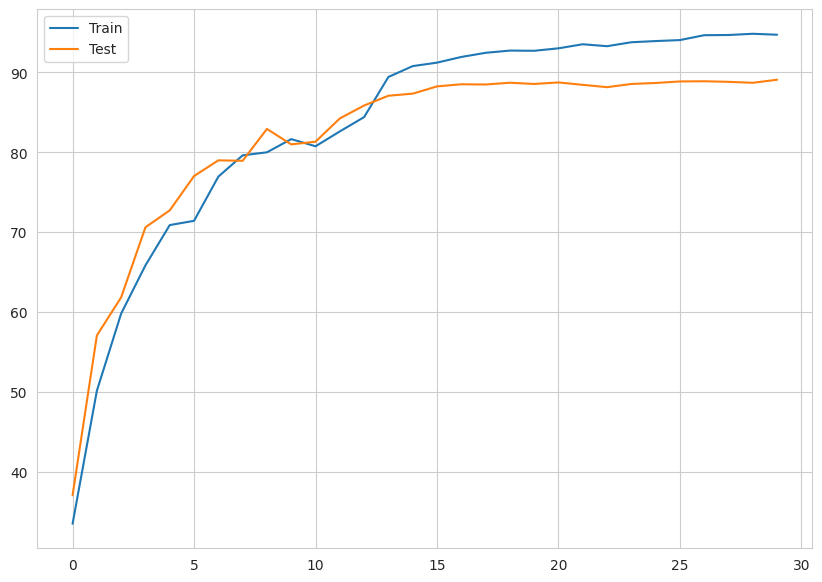

In [26]:
import seaborn

seaborn.set_style("whitegrid")

train_acc_res_1 = [i.cpu() for i in train_acc_res]
test_acc_res_1 = [i.cpu() for i in test_acc_res]

plt.figure(figsize=(10, 7))
plt.plot(train_acc_res_1, label="Train")
plt.plot(test_acc_res_1, label="Test")
plt.legend()
plt.show()

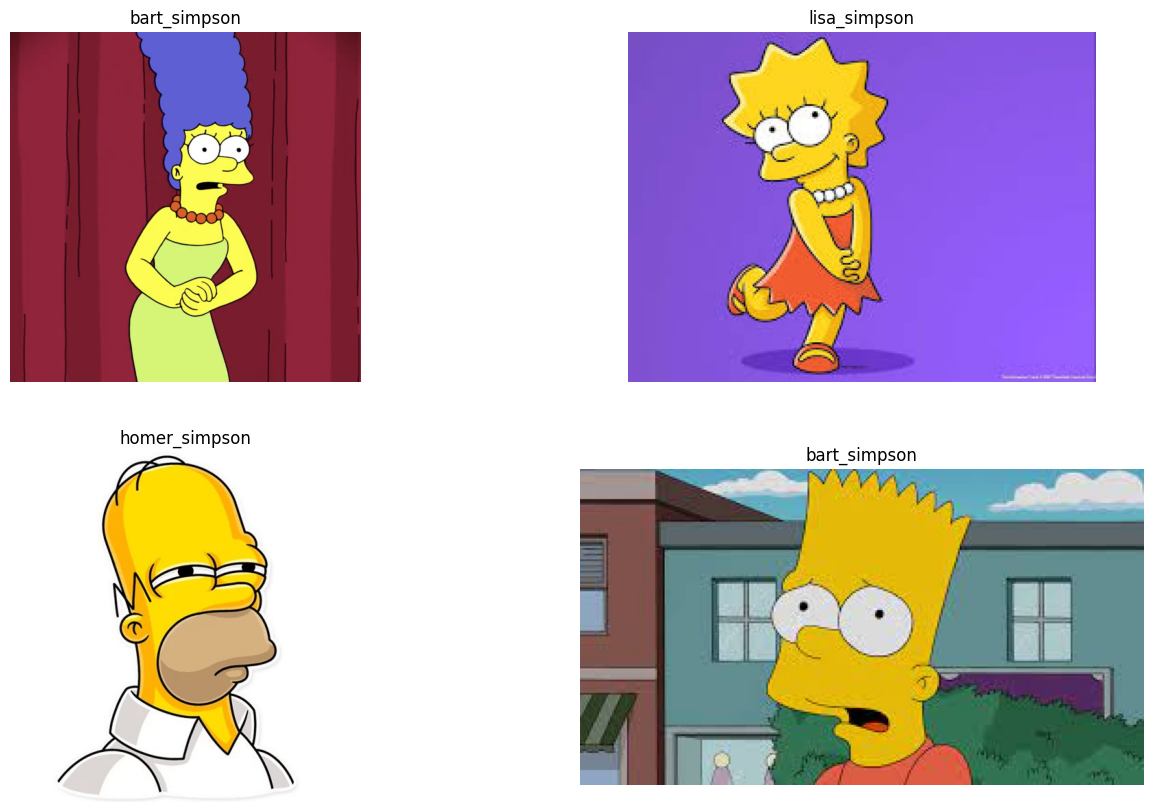

In [11]:
from PIL import Image

fig, ax = plt.subplots(2, 2, figsize=(16, 10))
ax = ax.ravel()
PHOTOS_PATH = Path('my_own_photos')
model.eval()

for ind, name in enumerate(list(os.walk("my_own_photos"))[0][2]):
    photo_path = PHOTOS_PATH / name
    img_orig = Image.open(photo_path)
    img = (trans(img_orig)).to(DEVICE)
    ax[ind].imshow(transforms.ToTensor()(img_orig).permute(1, 2, 0))
    with torch.inference_mode():
        preds = torch.sigmoid(model(img.unsqueeze(0)))
    ax[ind].set_title(class_names[preds.argmax(1)])
    ax[ind].axis(False)
    # вывод вероятностей для фотографии 
    # probs = {class_names[i]: preds[0][i].item() for i in range(len(class_names))}
    # print(f"Probs for {name.split('.')[0]}: {sorted(probs.items(), key=lambda x: x[1])[::-1]}")
plt.show()

In [52]:
model_name = Path("models") / ("model_" + str(test_acc_res[-1].item()).split('.')[0] + "_acc.pth")
torch.save(model.state_dict(), model_name)

In [10]:
loaded_model = SimpsonsModel(in_channels=3,
                             output=len(class_names)).to(DEVICE)
loaded_model.load_state_dict(torch.load(f="models/model_88_acc.pth"))

/tmp/ipykernel_6030/1510127036.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(f="models/model_88_acc.pth"))


<All keys matched successfully>

In [14]:
!ls

data  models  my_own_photos  simpsons.ipynb


In [15]:
test_df = pd.read_csv("sample_submission.csv")
test_df.head()

,Id,Expected
0,img0.jpg,bart_simpson
1,img1.jpg,bart_simpson
2,img2.jpg,bart_simpson
3,img3.jpg,bart_simpson
4,img4.jpg,bart_simpson


In [30]:
for ind, name in enumerate(test_df["Id"]):
    img = Image.open(f"data/test/{name}")
    img = trans(img).to(DEVICE)
    preds = torch.sigmoid(loaded_model(img.unsqueeze(0)))
    test_df.loc[ind]["Expected"] = class_names[preds.argmax(1)]

/tmp/ipykernel_6030/1771342214.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  test_df.loc[ind]["Expected"] = class_names[preds.argmax(1)]


In [31]:
test_df.head()

,Id,Expected
0,img0.jpg,barney_gumble
1,img1.jpg,bart_simpson
2,img2.jpg,mayor_quimby
3,img3.jpg,nelson_muntz
4,img4.jpg,lisa_simpson


In [33]:
test_df.to_csv("submission.csv", index=False) # итог 94% на kaggle